<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [13]:
# Импортируем необходимые библиотеки.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

In [14]:
# Импортируем данные, отсортируем их по дате.
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
#df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [15]:
# Ресемплируем данные по 1 часу.
df = df.resample('1H').sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


При загрузке датасета мы дату сразу перевели в формат DateTime и поместили его в индекс.

## Анализ

In [16]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


In [17]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Имеем 4416 записей, с 01 марта по 31 августа 2018 года. По количеству заказов в час - имеем разброс: от 0 (нет заказов) до 462.

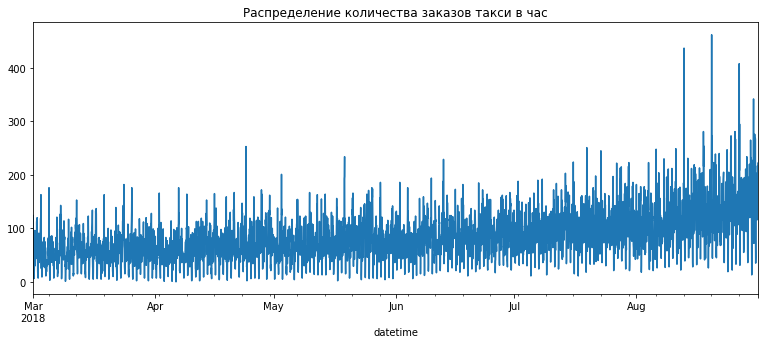

In [18]:
plt.figure(figsize=(13,5))
plt.title('Распределение количества заказов такси в час')
df['num_orders'].plot();

Временной ряд не стационарен. Со временем меняется его среднее значение и дисперсия. Имеются выбросы.

In [19]:
# Сделаем декомпозицию временного ряда, чтобы разложить его на тренды и сезонность
decomposed = seasonal_decompose(df['num_orders'])

Визуализируем тренд в середине анализируемого периода, в течение недели, с понедельника по воскресенье:

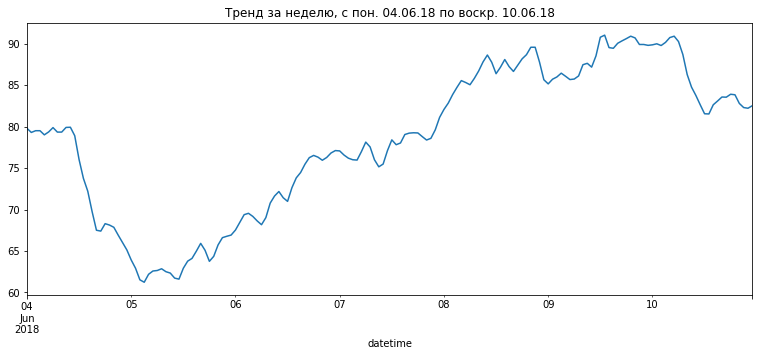

In [20]:
plt.figure(figsize=(13,5))
plt.title('Тренд за неделю, с пон. 04.06.18 по воскр. 10.06.18')
decomposed.trend['2018-06-04':'2018-06-10'].plot();

Визуализируем сезонность в середине анализируемого периода, в течение 2-х дней, в среду и в четверг:

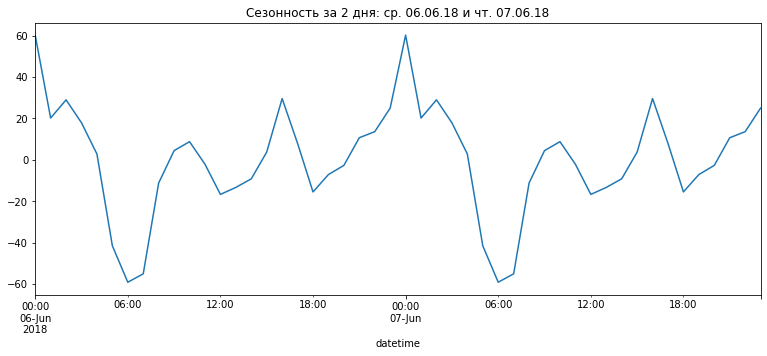

In [21]:
plt.figure(figsize=(13,5))
plt.title('Сезонность за 2 дня: ср. 06.06.18 и чт. 07.06.18')
decomposed.seasonal['2018-06-06':'2018-06-07'].plot();

Видно, что количество заказов меняется в течение недели (ко вторнику падают, далее со среды начинается рост, с пиком в период с пятницы по воскресенье). По сезонности видим, что количество заказов меняется волнами в течении дня (связано с графиком прилёта рейсов, день-ото дня эти волны повторяются по времени).

## Обучение

In [11]:
# Функция подбора количества лагов и скользящего среднего
def make_features(dframe, max_lag, rolling_mean_size):
    df_copy = dframe.copy()
    df_copy['month'] = df_copy.index.month
    df_copy['day'] = df_copy.index.day
    df_copy['dayofweek'] = df_copy.index.dayofweek
    for lag in range(1, max_lag + 1):
        df_copy['lag_{}'.format(lag)] = df_copy['num_orders'].shift(lag)
    df_copy['rolling_mean'] = df_copy['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    df_copy = df_copy.dropna()
    feat = df_copy.drop(columns=['num_orders'])
    targ = df_copy.num_orders
    feat_train, feat_test, targ_train, targ_test = train_test_split(feat, targ, shuffle=False, test_size=0.1)

    model = LinearRegression()
     
    score = -cross_val_score(model, feat_train, targ_train, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit()).mean()
    return score

In [12]:
# Подберём оптимальное количество лагов и скользящее среднее
best_rmse = 9999999999999999999999999
best_lag = 0
best_rolling = 0
for r in range(1, 25):
    for i in range(1, 25):
        rmse = make_features(df, i, r)
        if rmse < best_rmse:
            best_rmse = rmse
            best_lag = i
            best_rolling = r
print('best_rmse:', best_rmse.round(2))
print('best_lag:', best_lag)
print('best_rolling:', best_rolling)

Для подбора параметров была применена Линейная регрессия. Лучшее RMSE на ней получилось 27.03 при 24 логах и шириной скользящего среднего = 5.

Создадим признаки для горизонта прогнозирования, в соответствии с этими найденными параметрами:

In [13]:
data = df.copy()
data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
for l in range(1, best_lag + 1):
    data['lag_{}'.format(l)] = data['num_orders'].shift(l)
data['rolling_mean'] = data['num_orders'].shift().rolling(best_rolling).mean()
data.head(25)

In [14]:
# Удалим строки с пропусками в начале датасета
data = data.dropna()
data.head()

In [15]:
# Выделим целевой признак
features = data.drop(columns=['num_orders'])
target = data.num_orders

In [16]:
# Разделим данные на обучающую и тестовую выборки.
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)

**I. Линейная регрессия**

In [18]:
model_lr = LinearRegression()
rmse_lr = -cross_val_score(model_lr, features_train, target_train, scoring='neg_root_mean_squared_error',
                           cv=TimeSeriesSplit()).mean()
print("RMSE:", rmse_lr)

RMSE линейной регрессии на обучающей выборке 27.03

**II. Дерево решений**

In [19]:
model_dtr= DecisionTreeRegressor(random_state=12345)
param_grid = {"max_depth" : range(10,13), 'min_samples_leaf': range(49,52)}
gsearch = GridSearchCV(model_dtr, param_grid = param_grid, n_jobs=-1, scoring='neg_root_mean_squared_error',
                       cv=TimeSeriesSplit())
dtr_model = gsearch.fit(features_train,target_train)
print(f'Лучшая RMSE: {-dtr_model.best_score_} при параметрах {dtr_model.best_params_}')

Лучшая RMSE: 28.94 при параметрах {'max_depth': 11, 'min_samples_leaf': 50}

**III. Случайный лес**

In [20]:
model_rfr= RandomForestRegressor(random_state=12345, n_jobs=-1)
param_grid = {
    "max_depth" : range(26,29),
    "n_estimators" : range(465,468)
}
gsearch = GridSearchCV(model_rfr, param_grid = param_grid, n_jobs=-1, scoring='neg_root_mean_squared_error',
                       cv=TimeSeriesSplit())
rfr_model = gsearch.fit(features_train,target_train)
print(f'Лучшая RMSE: {-rfr_model.best_score_} при параметрах ,{rfr_model.best_params_}')

Лучшая RMSE: 25.55 при параметрах: Глубина-27, Оценщиков-466.

**IV. LGBM**

In [21]:
model_lgbm = LGBMRegressor(random_state=12345, metric=rmse, n_jobs=-1)
param_grid = {
    'learning_rate' : np.arange(0.11, 0.14, 0.01),
    'boosting_type' : ['gbrt', 'dart', 'goss'],
    'max_depth' : range(3,6)
}
gsearch = GridSearchCV(model_lgbm, param_grid = param_grid, n_jobs=-1, scoring='neg_root_mean_squared_error',
                       cv=TimeSeriesSplit(n_splits=5))
lgbm_model = gsearch.fit(features_train,target_train)
print(f'Лучшая RMSE: {-lgbm_model.best_score_} при параметрах ,{lgbm_model.best_params_}')

Лучшая RMSE: 25.37 при параметрах: 'boosting_type'-'gbrt', 'learning_rate': 0.12, 'max_depth': 4

In [22]:
# Запишем данные всех моделей вместе
models = []
models.append([27.03])
models.append([28.94])
models.append([25.55])
models.append([25.37])

In [23]:
model_table = pd.DataFrame(data=models, index=['Линейная регрессия', 'Дерево решений', 'Случайный лес', 'LightGBM'],
                           columns=['RMSE'])

In [24]:
model_table

**Вывод**

Самая лучшая модель: LightGBM (RMSE=25.37) со следующими настройками: 'boosting_type': 'gbrt', 'learning_rate': 0.12, 'max_depth': 4

## Тестирование

In [25]:
# Протестируем наилучшую модель на тестовой выборке
predictions = lgbm_model.predict(features_test)
print('RMSE модели LightGBM на тестовой выборке:', mean_squared_error(target_test, predictions, squared = False))

In [26]:
plt.figure(figsize=(13, 6)) 
plt.scatter(y=target_test, x=target_test.index, label='Реальные тестовые значения')
plt.scatter(y=predictions, x=target_test.index, label='Предсказанные значения')
plt.legend(loc='upper left')
plt.title('Отличие реальных тестовых данных от предсказанных лучшей моделью LGBMRegressor')
plt.show()

**Выводы**

Для прогнозирования количества заказов такси на следующий час в период пиковой нагрузки, были построены 4 модели предскания: 'Линейная регрессия', 'Дерево решений', 'Случайный лес', 'LightGBM'. Наиболее эффективная модель - 'LightGBM', она показала минимальную метрику RSME. 
RMSE нашей модели на тестовой выборке (41,35) стал выше, чем на тренировочной (25.37), но удовлетворяет нашему требованию в задании (Значение метрики RMSE на тестовой выборке должно быть не больше 48).
Визуализированы результаты, показывающие предсказанные значения лучшей модели и реальные тестовые значения.